Implementation of the **GradCAM** method for interpretability of Vision Classification Models.

This is the notebook report of a Practical Session in the **Deep Learning in Practice** course (G. Charpiat).

Author: Gabin Agbale

## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request
import torch.nn.functional as F

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
We use ResNet34 for our experiments.

In [ ]:
resnet34 = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')  # New PyTorch interface for loading weights!
resnet34.eval() # set the model to evaluation mode

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224).

First convolution layer with maxpool.
Then 4 ResNet blocks.

Output of the last ResNet block is of size (512x7x7).

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [ ]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [ ]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [ ]:
import os
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP2_images"):
    os.mkdir("data/TP2_images")
    !cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip

dir_path = "data/"
dataset = preprocess_image(dir_path)

--2024-08-04 09:29:51--  https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip
Resolving www.lri.fr (www.lri.fr)... 129.175.15.11
Connecting to www.lri.fr (www.lri.fr)|129.175.15.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477062 (1.4M) [application/zip]
Saving to: ‘TP2_images.zip’

TP2_images.zip      100%[===================>]   1.41M  1.45MB/s    in 1.0s    

2024-08-04 09:29:54 (1.45 MB/s) - ‘TP2_images.zip’ saved [1477062/1477062]

Archive:  TP2_images.zip
   creating: .ipynb_checkpoints/
  inflating: 155881293_721e90b57d.jpg  
  inflating: 158850087_3251644046.jpg  
  inflating: 1624593475_146bf1f7ff.jpg  
  inflating: 181748579_01a4611736.jpg  
  inflating: 2068921624_ef0986de13.jpg  
  inflating: 2637374064_fab14ec0b8.jpg  
  inflating: 2749465889_8e62023674.jpg  
  inflating: 2936812850_23bf0d1cfd.jpg  
  inflating: 3532471222_a6d7e3780e.jpg  
  inflating: 3633913271_ee789a3bc4.jpg  
  inflating: 3633949157_f577605ea9.jpg  
  infla

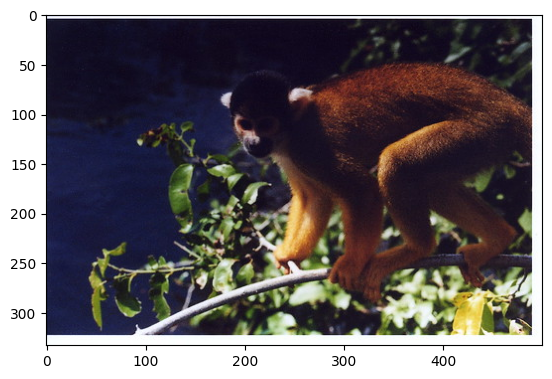

In [ ]:
# show the orignal image
index = 19
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

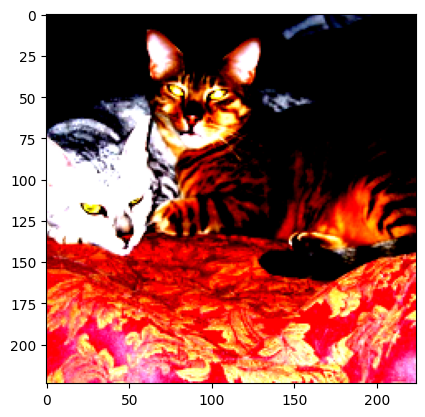

In [ ]:
plt.imshow(dataset[5][0].view(1, 3, 224, 224).squeeze(0).permute(1, 2, 0))

In [ ]:
output = resnet34(dataset[5][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [13.175315 11.065538 10.584751]


### Grad-CAM
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | -
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

In [ ]:
def Grad_CAM(model, image, target, layer_name):

  layer = None
  for name, module in model.named_modules():
    if layer_name == name:
      layer = module

  # hook function saving grad_ouput during backpropagation
  def backward_hook(self, grad_input, grad_output):
    global GRAD_OUTPUT
    GRAD_OUTPUT = grad_output


  # hook function saving ouput during forward pass
  def forward_hook(self, input, output):
    global OUTPUT
    OUTPUT = output

  # We register hook functions on the given layer
  backward_hook = layer.register_full_backward_hook(backward_hook)
  forward_hook = layer.register_forward_hook(forward_hook)

  # forward pass to get raw class scores and save feature map values
  output_ = model(image)
  model.zero_grad()


  # backward pass on modified gradient
  one_hot_gradient = torch.zeros_like(output_)
  one_hot_gradient[:, target] = 1
  output_.backward(gradient=one_hot_gradient, retain_graph=True)

  # compute Grad-CAM
  feature_maps = OUTPUT.squeeze(0)
  gradients = GRAD_OUTPUT[0].squeeze(0)

  num_pixels = gradients.shape[-1]**2
  feature_weights = 1/num_pixels * gradients.sum(axis=(1, 2))

  heatmap = (feature_maps * feature_weights.unsqueeze(1).unsqueeze(2)).sum(axis=0)

  # remove hooks
  backward_hook.remove()
  forward_hook.remove()

  return heatmap

In [ ]:
def draw_grad_CAM(layer_name):
  for index in range(20):
    output = resnet34(dataset[index][0].view(1, 3, 224, 224))
    values, indices = torch.topk(output, 3)

    indices_to_display = indices[0].detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    original_image = dataset[index][0].view(1, 3, 224, 224).squeeze(0).permute(1, 2, 0).numpy()

    for i, idx in enumerate(indices_to_display):
        heatmap = Grad_CAM(resnet34, dataset[index][0].view(1, 3, 224, 224), idx, layer_name)
        heatmap_rescaled = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0).detach(), size=(224, 224), mode='bilinear')

        # Normalize heatmap_rescaled
        heatmap_rescaled = (heatmap_rescaled - heatmap_rescaled.min()) / (heatmap_rescaled.max() - heatmap_rescaled.min())
        original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

        axes[i].imshow(original_image)
        axes[i].imshow(heatmap_rescaled.squeeze().squeeze(), alpha=0.4, cmap='jet')
        axes[i].set_title(f'class {classes[idx]}')
        axes[i].axis('off')

  plt.show()

  return None

# GRAD-CAM FOR LAST RESNET LAYER

In [ ]:
draw_grad_CAM('layer4')

Output hidden; open in https://colab.research.google.com to view.

we observe that the grad-CAM usually refers to the same elements in the image, despite the class studied (Animal's head seem to be a good discriminant for the classification). There are images where the grad-cam detects two instances in a same image, as seen in the case of the great Dane (8th picture).

# GRAD-CAM FOR FIRST RESNET LAYER

In [ ]:
draw_grad_CAM('layer1')

Output hidden; open in https://colab.research.google.com to view.

# GRAD-CAM FOR SECOND RESNET LAYER

In [ ]:
draw_grad_CAM('layer2')

Output hidden; open in https://colab.research.google.com to view.

# GRAD-CAM FOR THIRD RESNET LAYER

In [ ]:
draw_grad_CAM('layer3')

Output hidden; open in https://colab.research.google.com to view.

We notice first that the regions of importance covered by the grad-CAM get wider as we look further into the layers. This is due to the fact that each pixel in each feature map of the latest layers aggregates for a broader area in the input image.

Secondly, as we get deeper into the layers, the grad-CAM highlights more relevant regions of the images, for example animals' muzzle, while earlier layers might highlight biased features. For example in the case of the 14th image of the dataset (see below), we can see that layer 3 relies mostly on the surrounding environment (which might be observed in every Impala image), while the last convolutional layer focuses on the animal.

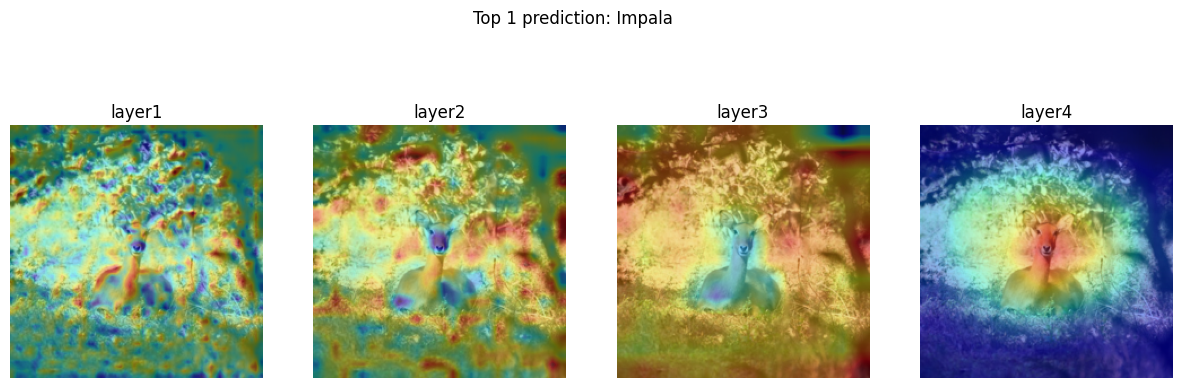

In [ ]:
index = 13
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
dominant_class = indices[0].detach().numpy()[0]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Top 1 prediction: Impala')
for i, layer_name in enumerate(['layer1', 'layer2', 'layer3', 'layer4']):
  heatmap = Grad_CAM(resnet34, dataset[index][0].view(1, 3, 224, 224), dominant_class, layer_name)
  heatmap_rescaled = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0).detach(), size=(224, 224), mode='bilinear')

  # Normalize heatmap_rescaled
  original_image = dataset[index][0].view(1, 3, 224, 224).squeeze(0).permute(1, 2, 0).numpy()
  heatmap_rescaled = (heatmap_rescaled - heatmap_rescaled.min()) / (heatmap_rescaled.max() - heatmap_rescaled.min())
  original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

  axes[i].imshow(original_image)
  axes[i].imshow(heatmap_rescaled.squeeze().squeeze(), alpha=0.4, cmap='jet')
  axes[i].set_title(f'{layer_name}')
  axes[i].axis('off')

GradCAM allows us to highlight regions of importance in the classification task and potential biases (like spurious correlations, when Grad-CAM highlights elements other than the object of interest that are usually associated with it). It does not require any change in the architecure, nor re-training.